In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import seaborn as sns
import os
import time
import random
from utils.metrics import *

In [2]:
randdata=[42, 168, 573, 81, 1094 , 9,
 23, 1387, 937 ,1]  #  np.random.random_sample(10)
#print(randdata)

In [3]:
# setting random seed
SEED=randdata[0]   
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
dicdata='../../Datasets/'
dicnpy='../../dataUNSW/'
dicoutcome='../../unsw_checkpoints/'

In [5]:
def column_split_bina(ds):
    '''split dataset to data_x,data_y for binary classification '''
    if type(ds)==pd.DataFrame:
        data_x=np.asarray(ds.iloc[:,:-2]).astype(np.float32)
        data_y=np.asarray(ds.iloc[:,-1]).astype(np.float32)
    elif type(ds)==np.ndarray:
        data_x=ds[:,:-2].astype(np.float32)
        data_y=ds[:,-1].astype(np.float32)        
    else:
        data_x=False
        data_y=False
    return data_x, data_y

In [6]:
# Get the training data
try:
    normal_train=np.load(dicnpy+'Normal_train_80_2.npy',allow_pickle=True)
    normal_test=np.load(dicnpy+'Normal_test_20_2.npy',allow_pickle=True)
except IOError:
    print("Normal.npy didn't exist!")
    
normal_train_x, _ =column_split_bina(normal_train)
original_dim = normal_train_x.shape[1]
input_shape = (original_dim,)

klw=normal_train_x.shape[0]
#intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

# build model

In [13]:

def make_n_prior(shape, dtype=np.float32,independent=False):
    if independent:
        return   tfd.Independent(tfd.Normal(loc=tf.zeros(shape), scale=1),  reinterpreted_batch_ndims=1)
    else:
        return tfd.Normal(loc=tf.zeros(shape), scale=1)   # scale=0.01 ?
    
tfb = tfp.bijectors

def make_mvn_prior(ndim, trainable=False, offdiag=False):
        if not trainable:
            if offdiag:
                # With covariances
                # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.zeros(ndim),
                    scale_tril=tf.eye(ndim)
                )
            else:            
                if True:  # kl_exact needs same dist types for prior and latent.
                    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
                else:
                    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                            reinterpreted_batch_ndims=1)
        else:
            # Note, in TransformedVariable, the initial value should be that AFTER transform; weight trainable.
            if offdiag:
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_tril=tfp.util.TransformedVariable(
                        tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        tfb.FillScaleTriL(), name="prior_scale")
                )
            else:
                scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
                prior = tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_diag=tfp.util.TransformedVariable(
                        tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                        name="prior_scale"
                    )
                )                
        return prior

In [15]:
# 2 layers (128,64,32)
#prior =tfd.Independent(tfd.Normal(loc=tf.zeros(64), scale=1)    , reinterpreted_batch_ndims=1)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(128,  activation='relu'), 
    tfkl.Dense(64, activation='relu'),         
    tfkl.Dense( 32,  
               activation='relu'),
    
# ###  when in VAE, uncomment the next two lines.
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
#         kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
#         bias_initializer=tf.zeros_initializer() ),
#     tfpl.MultivariateNormalTriL( 32, activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(32) ,use_exact_kl=False, weight=1.0)) 
  
])


encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               6144      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 560)               18480     
                                                                 
 multivariate_normal_tri_l_1  ((None, 32),             0         
  (MultivariateNormalTriL)    (None, 32))                        
                                                                 
Total params: 34,960
Trainable params: 34,960
Non-trainable params: 0
__________________________________________________

In [16]:
#  decoder model
latent_inputs =tfk. Input(shape=(32,), name='z_sampling')
x = tfkl.Dense(64,
               activation='relu')(latent_inputs)

x = tfkl. Dense(128, 
                activation='relu')(x)

outputs=tfkl.Dense(original_dim,
                    activation='sigmoid')(x)

decoder=tfk.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 47)                6063      
                                                                 
Total params: 16,495
Trainable params: 16,495
Non-trainable params: 0
_________________________________________________________________


In [17]:
 
loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class AE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="ae", **kwargs):
        super(AE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        z_sample=self.encoder(x_input)                
        x_recons=self. decoder(z_sample   )#.sample() )
        
        return x_recons
     
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            z_sample=self.encoder(x_true)
            x_recons=self. decoder(z_sample  )#.sample())
                        
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            
            total_loss =reconstruction_loss 
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    

# Training model

In [8]:
# M=5   # the true M=1 when minibatch big enough,>100
savename="unsw-1-AE-seed0-mae"

In [9]:
# scale data
t = MinMaxScaler()
t.fit(normal_train_x)
normal_train_x = t.transform(normal_train_x)

In [18]:
# compile and train tfk.Model
BDL_model = AE_AD(orig_dim=original_dim)
BDL_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08,amsgrad=True))#decay=1.0/200,  # not good of Adam and decay
batchsize=512
epochsize=100
start=time.time()
train_history= BDL_model.fit(normal_train_x, batch_size=batchsize,epochs=epochsize,shuffle=True)
end=time.time()
print(f"\nTime to training: {round(end-start,5)} seconds.")

Epoch 1/100
3467/3467 [==============================] - 19s 5ms/step - loss: 0.1224 - reconstruction_loss: 0.0695
Epoch 2/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0368 - reconstruction_loss: 0.0351
Epoch 3/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0318 - reconstruction_loss: 0.0312
Epoch 4/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0304 - reconstruction_loss: 0.0302
Epoch 5/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0296 - reconstruction_loss: 0.0294
Epoch 6/100
3467/3467 [==============================] - 18s 5ms/step - loss: 0.0292 - reconstruction_loss: 0.0291
Epoch 7/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0290 - reconstruction_loss: 0.0289
Epoch 8/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.0287 - reconstruction_loss: 0.0286
Epoch 9/100
3467/3467 [==============================] - 17s 5ms/step - loss: 0.

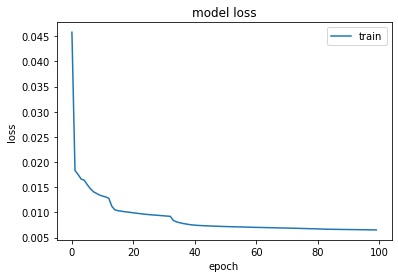

In [11]:

pyplot.plot(train_history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right');
pyplot.show()

# save or load model

In [19]:
# # Save the weights
BDL_model.save_weights('./unsw_checkpoints/'+savename)

In [18]:
BDL_model = AE_AD(orig_dim=original_dim)
#oldsavename='unsw-1-AE-mae' # None  # the old file name 
## Restore the weights
BDL_model.load_weights('./unsw_checkpoints/'+savename)# oldsavename)  
#savename='the future name'

## Evaluate the model
#loss, acc = BDL_model.evaluate(normal_train_x)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# function set

In [20]:
attack_types=['Normal','Shellcode','Exploits','Fuzzers','Reconnaissance','Generic','Worms','Analysis','DoS','Backdoors','AllAttacks']

In [21]:

def metric3UQ(fileforname, skiprow=None):
    pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BDL'+fileforname+'+allmetrics.csv'   ,skiprows=skiprow)   
    save_path="pplots/BDL"+fileforname+'+allmetricsSum'+".csv"
    
    modelname='BDL'
    model_dict_total={}
    model_dict_alea={}
    model_dict_epis={}
    model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
    for each in range(1,len( attack_types)):
        fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
        fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')

        for i in range(1,len(pd_reader),18*3):
            if '+' in pd_reader.iloc[i,0] :

                if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                    legendd=pd_reader.iloc[i,0].split('+')[0]

                    if legendd in model_dict_total.keys():
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)

                    else: 
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16)  

                    #fig_title=pd_reader.iloc[i,0]
                    try:
                        xx=pd_reader.iloc[i+2,1:].astype(int)
                    except:
                        print(i)

                    # total uncertainty
                    y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                    y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                    y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                    #plot_title=pd_reader.iloc[i+2,0]            
                    #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                    y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                    y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                    y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis

                    # ACCU_total
                    ax1.plot(xx,y_values,label=legendd)                
                    ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                    ax1.set(ylabel='Percent')              
                    # ACCU_alea
                    ax2.plot(xx, y_values2) # , 'tab:green')        
                    ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                    # ACCU_epis
                    ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                    ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         

                    # AUC
                    ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 

                    #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test

                    if each==1:
                        ax1.set_title('Total')
                        ax2.set_title('Aleatoric') 
                        ax3.set_title('Epistemic')
                        ax4.set_title('AUC') 
                    if each==len(attack_types)-1:
                        ax1.set(xlabel='Rejection')
                        ax2.set(xlabel='Rejection')
                        ax3.set(xlabel='Rejection')
                        ax4.set(xlabel='Rejection')
                    
                    #i=i+18*3  


        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))

        for ax in fig.get_axes():
            ax.label_outer()
            ax.set_xlim(0,60)
            ax.set_ylim(0,1)
       
        pyplot.show()

    for aproblegend in model_dict_total.keys():
        if aproblegend != 'metricname':
            model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)
            model_dict_alea[aproblegend]=model_dict_alea[aproblegend]/(len(attack_types)-1)
            model_dict_epis[aproblegend]=model_dict_epis[aproblegend]/(len(attack_types)-1)

    save_data=pd.DataFrame(model_dict_total)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_alea)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_epis)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [22]:
def get_error_term(v1,v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1-v2)**2,axis=1))
    else:        #return MAE
        return np.mean(abs(v1-v2),axis=1)

# 1.testing+more dist

In [23]:
#import os
'''
all the epistemic uncertainty equals zero
'''
alluncertainty_1_dict={}     # record all UQ under multiple distributions on anoamly score. using rmse
all_AS_AP_1_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats. using mae
all_AS_AP_2_dict={}  # using MSE to calculate anoamly score

all_test_y_2_dict={}
newname=savename  +'-mae'
T=1   # AE,VAE no need sample multiple times for epistimic.  # the times of prediction, i.e. the number of parameters samples.
distribution_types=['G1','G2', 'Triang', 'GC','Gamma', 'Uniform','T','ECDF'
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
'''
#start to timeing
start=time.time()
for root,dirs,files in os.walk(dicnpy):
    for each in files:
        if (dicnpy+each).endswith('.npy'):        
            #temp=pd.concat([single_group,normal_train],axis=0)
            if each!='Normal.npy' and each.split('_')[0]!='Normal':
                print(each)
                cont=np.load(dicnpy+each,allow_pickle=True)
                testdata=np.concatenate([cont,normal_test],axis=0)  
                test_x,test_y=column_split_bina(testdata)
                if type(test_x)==False:
                    print('test_x is False!')
                
                all_test_y_2_dict[each]=test_y
                # scale data
                t = MinMaxScaler()
                t.fit(test_x)
                test_x2 = t.transform(test_x)
                # for rmse
                mean_1_G1, mean_1_G2, mean_1_GC, mean_1_Gamma, mean_1_Poisson, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF, mean_1_ECOD=0,0,0,0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
              
                for i in range(0,T):
                    test_recon=BDL_model.predict(test_x2)
                          
                
                    AS_1_vector = get_error_term(test_recon, test_x2, _rmse=False) 
                    all_AS_AP_1_dict[each+'_AS_'+str(i)]=AS_1_vector
                    mean_1_AS=mean_1_AS+AS_1_vector
                    
                    AS_2_vector = get_error_term(test_recon, test_x2, _rmse=True) 
                    all_AS_AP_2_dict[each+'_AS_'+str(i)]=AS_2_vector
                
                    # test 2.1------------------------standard Gaussian------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 1.the anomaly scores following Gaussian distribution                   
                    AS_1_vector_prob=normalization_gaussian_1( AS_1_vector_prob)     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G1']=AS_1_vector_prob
                    mean_1_G1=mean_1_G1+AS_1_vector_prob
                    
                   
                     #-------------------Customized Gaussian using CDF-----------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)   ######################
                    #AS_1_vector_prob=regular_linear(AS_1_vector) 
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector)                    
                    # 2.the anomaly scores following Gaussian distribution 
                    AS_1_vector_prob=normalization_gaussian_2(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_G2']=AS_1_vector_prob 
                    mean_1_G2=mean_1_G2+AS_1_vector_prob
                    
                    # 4.the anomaly scores following Gamma distribution -----------------------------------------------
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector )                      
                    AS_1_vector_prob=normalization_gamma(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Gamma']=AS_1_vector_prob
                    mean_1_Gamma=mean_1_Gamma+AS_1_vector_prob

                                       
                     # 5.the anomaly scores following poisson distribution   ------------------------------ 
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector  )                     
                    AS_1_vector_prob=normalization_poisson(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Poisson']=AS_1_vector_prob
                    mean_1_Poisson=mean_1_Poisson+AS_1_vector_prob

                                        
                     # 6.the anomaly scores following uniform distribution -----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                     
                    AS_1_vector_prob=normalization_uniform(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Uniform']=AS_1_vector_prob
                    mean_1_Uniform=mean_1_Uniform+AS_1_vector_prob
                     
                    # 7.the anomaly scores following Triang distribution   ----------------------------------   
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    #AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=copy.deepcopy(AS_1_vector )                     
                    AS_1_vector_prob=normalization_triang(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_Triang']=AS_1_vector_prob
                    mean_1_Triang=mean_1_Triang+AS_1_vector_prob
                    
                     # 8.the anomaly scores following students  t distribution   ----------------------------------  
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    #AS_1_vector_prob=copy.deepcopy(AS_1_vector)                  
                    AS_1_vector_prob=normalization_t(AS_1_vector_prob)
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_T']=AS_1_vector_prob
                    mean_1_T=mean_1_T+AS_1_vector_prob
                    
                    '''
                    # test 9 -----------------------pure CDF-------------------------------------
                    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
                    #3. alternative: pure cdf()   
                    #AS_1_vector_prob=stats.norm.cdf(AS_1_vector)  
                    '''
                    #-------------------------------ECDF-----------------------------------------
                    # 3.1 ecdf       
                    #AS_1_vector_prob=regular_log(AS_1_vector)
                    AS_1_vector_prob=regular_linear(AS_1_vector)
                    AS_1_vector_prob=normalization_ECDF(AS_1_vector_prob)
                    #AS_1_vector_prob=cdf_ECDF( AS_1_vector_prob)                     
                    all_AS_AP_1_dict[each+'_AP_'+str(i)+'_ECDF']=AS_1_vector_prob
                    mean_1_ECDF=mean_1_ECDF+AS_1_vector_prob
                                                          
                mean_AP={}
                mean_AP['AS']=mean_1_AS/T
                mean_AP['G1']=mean_1_G1/T
                mean_AP['G2']=mean_1_G2/T
                mean_AP['Gamma']=mean_1_Gamma/T
                mean_AP['Uniform']=mean_1_Uniform/T
                mean_AP['Triang']=mean_1_Triang/T
                mean_AP['T']=mean_1_T/T
                mean_AP['ECDF']=mean_1_ECDF/T
                mean_1_G1, mean_1_G2, mean_1_Gamma, mean_1_Uniform,mean_1_Triang, mean_1_T,mean_1_ECDF=0,0,0,0,0,0,0
                mean_1_AS=0     # the averaging of anomaly scores
               
                mean_1_alea={}
                mean_1_epis={}
                for dist in distribution_types:
                    mean_1_alea[dist]=0
                    mean_1_epis[dist]=0
                    
                mean_AS_1_alea=0
                mean_AS_1_epis=0
                    
                for i in range(0,T):  
                    mean_AS_1_alea+= all_AS_AP_1_dict[each+'_AS_'+str(i)]*(1-all_AS_AP_1_dict[each+'_AS_'+str(i)])  # for Bonulli distribution  #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                    
                    for dist in distribution_types:
                        if all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                            # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                            mean_1_alea[dist] += np.mean(all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                            
                        else:
                            mean_1_alea[dist] += all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_1_dict[each+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                                                  
                mean_AS_1_alea=mean_AS_1_alea/T
                mean_AS_1_epis=np.zeros_like(mean_AS_1_alea)
                alluncertainty_1_dict[each+'_AS_alea']=mean_AS_1_alea
                alluncertainty_1_dict[each+'_AS_epis']=mean_AS_1_epis
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea+mean_AS_1_epis, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_alea, y_true=test_y,plot=False) 
                result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+each, ascores=mean_AP['AS'], 
                                            unc_total=mean_AS_1_epis, y_true=test_y,plot=False) 
                
                              
                for dist in distribution_types:
                    mean_1_alea[dist]=mean_1_alea[dist]/T
                    mean_1_epis[dist]=np.zeros_like(mean_1_alea[dist]))                   
                    alluncertainty_1_dict[each+'_'+dist+'_alea']=mean_1_alea[dist] 
                    alluncertainty_1_dict[each+'_'+dist+'_epis']=mean_1_epis[dist] 
                    uncer_1_total=mean_1_alea[dist] +mean_1_epis[dist]
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=uncer_1_total, y_true=test_y,plot=False)  #uncer_total
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                            unc_total=mean_1_alea[dist], y_true=test_y,plot=False) 
                    result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+each, ascores=mean_AP[dist], 
                                unc_total=mean_1_epis[dist], y_true=test_y,plot=False) 
                    
                 #break
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dic,   mean_1_G1, mean_1_G2, mean_1_Gamma, mean_1_Uniform,mean_1_Triang, 
del mean_1_T,mean_1_ECDF, mean_1_AS    
del AS_1_vector, AS_2_vector, AS_1_vector_prob

Shellcode.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Exploits.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Fuzzers.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Reconnaissance.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Generic.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Worms.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Analysis.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

AllAttacks.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

DoS.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

Backdoors.npy


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

In [24]:

uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_1_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_1_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del save_uncer,save_ASAP,alluncertainty_1_dict,all_AS_AP_1_dict

In [ ]:
print(newname)
metric3UQ(newname)    #'unsw-1-vi-input-mae-mse' ,skiprow=lambda x: x in [1,271])